In [ ]:
import torch
#from torch.utils.data import Dataset, DataLoader
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
from scipy import ndimage
from scipy.ndimage import zoom, map_coordinates

# Data exploration for Cell tracking


Let explore the training data set DIC-C2DH-HeLa



Image shape: (512, 512)
Image dtype: uint8


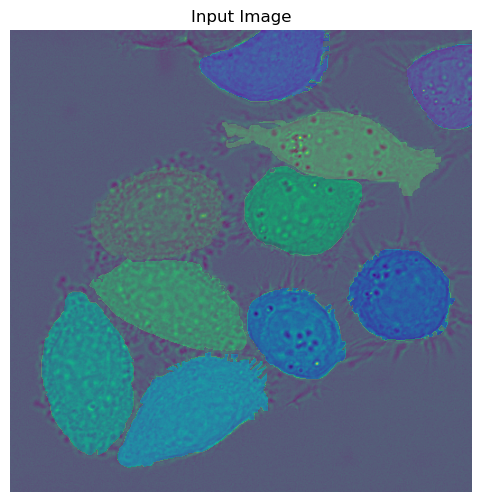

In [36]:
# Data exploration
# Load a sample image
im_path = "DIC-HeLa/01/t002.tif"
GT_seg_path = "DIC-HeLa/01_GT/SEG/man_seg002.tif"

img = io.imread(im_path)
img_seg_gt = io.imread(GT_seg_path)
print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")


plt.figure(figsize=(6, 6))
plt.imshow(img) # Grayscale image
plt.imshow(img_seg_gt, alpha=0.2, cmap='gist_rainbow') # Overlay ground truth segmentation with transparency
plt.title("Input Image")
plt.axis('off')
plt.show()

In [ ]:
def download_data():
    data_dir = "DIC-HeLa"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Data directory '{data_dir}' created. Please download the dataset manually.")
    else:
        print(f"Data directory '{data_dir}' already exists.")

    return None

# Data exploration for EM Segmentation


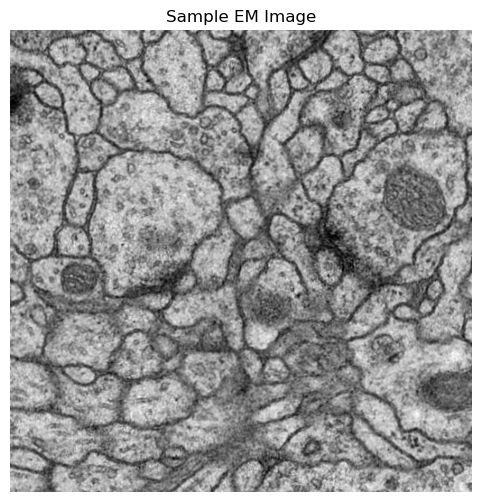

In [131]:
train_images_dir = "em-seg/train/imgs"
train_labels_dir = "em-seg/train/labels"

im_path = os.path.join(train_images_dir, "frame_0001.png")
img = io.imread(im_path)
label_path = os.path.join(train_labels_dir, "frame_0001.png")
label = io.imread(label_path)
plt.figure(figsize=(6, 6))  
plt.imshow(img, cmap='gray')
plt.title("Sample EM Image")
plt.axis('off')
plt.show()

In [117]:
# One Image is 512x512 pixels
# Add a Resize operation to the data pipeline if needed ? 
print(img.shape)
# Number of images in the training set
train_image_files = os.listdir(train_images_dir)
print(f"Number of training images: {len(train_image_files)}")


(512, 512)
Number of training images: 30


In [ ]:
def download_data():
    data_dir = "em-seg/train"
    im_folder = os.path.join(data_dir, "imgs")
    label_folder = os.path.join(data_dir, "labels")    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Data directory '{data_dir}' created. Please download the dataset manually.")
    else:
        print(f"Data directory '{data_dir}' already exists.")
    

Data Augmentation through elastic deformation 

In [ ]:
def elastic_transform_paired(image, label, sigma=25, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    h, w = image.shape[:2]
    
    grid_size = 3
    grid_x = random_state.normal(0, sigma, size=(grid_size, grid_size))
    grid_y = random_state.normal(0, sigma, size=(grid_size, grid_size))

    yi = np.linspace(0, grid_size - 1, h)
    xi = np.linspace(0, grid_size - 1, w)
    xy_grid = np.meshgrid(yi, xi, indexing='ij')

    dx = ndimage.map_coordinates(grid_x, xy_grid, order=3, mode='reflect')
    dy = ndimage.map_coordinates(grid_y, xy_grid, order=3, mode='reflect')

    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    indices = [Y + dy, X + dx]

    image_warped = ndimage.map_coordinates(
        image, indices, order=1, mode='reflect'
    )

    label_warped = ndimage.map_coordinates(
        label, indices, order=0, mode='reflect'
    )

    return image_warped, label_warped

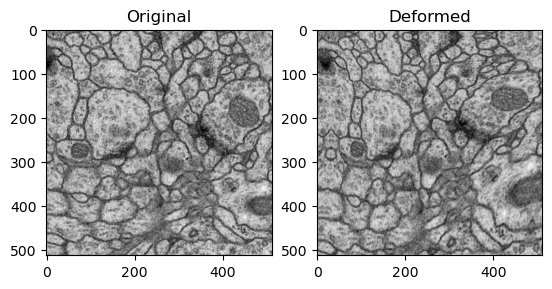

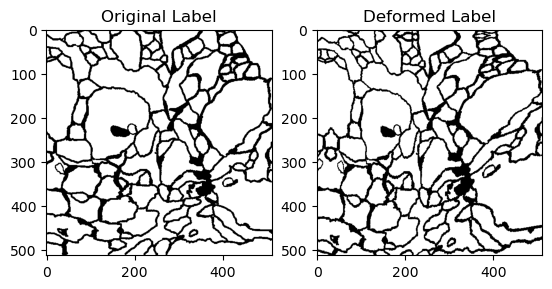

In [134]:
img_deformed, label_deformed = elastic_transform_paired(img, label)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, cmap="gray")
axarr[0].set_title("Original")
axarr[1].imshow(img_deformed, cmap="gray")
axarr[1].set_title("Deformed")

f , axarr = plt.subplots(1,2)
axarr[0].imshow(label, cmap="gray")
axarr[0].set_title("Original Label")
axarr[1].imshow(label_deformed, cmap="gray")
axarr[1].set_title("Deformed Label")
plt.show()

In [ ]:
from torch.utils.data import Dataset
import os
from skimage import io

class EMSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(self.root_dir, "train", "imgs")
        self.label_dir = os.path.join(self.root_dir, "train", "labels")
    
    def __len__(self):
        return len([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
    
    def retrieve_image(self, idx):
        img_name = f"frame_{idx + 1:04d}.png" # frame_0001.png
        img_path = os.path.join(self.image_dir, img_name)
        img = io.imread(img_path)
        return img
    
    def retrieve_label(self, idx):
        label_name = f"frame_{idx + 1:04d}.png" # frame_0001.png
        label_path = os.path.join(self.label_dir, label_name)
        label = io.imread(label_path)
        return label

    def __getitem__(self, idx):
        image = self.retrieve_image(idx)
        label = self.retrieve_label(idx)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        

In [ ]:
class EMSegmentationDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.root_dir = root_dir
        self.augment = augment  # Boolean flag instead of passing function directly
        self.image_dir = os.path.join(self.root_dir, "train", "imgs")
        self.label_dir = os.path.join(self.root_dir, "train", "labels")
    
    def __len__(self):
    
    def retrieve_image(self, idx):
        img_name = f"frame_{idx + 1:04d}.png"
        img_path = os.path.join(self.image_dir, img_name)
        # as_gray=True ensures (H, W), preventing dimension mismatches
        return io.imread(img_path, as_gray=True)
    
    def retrieve_label(self, idx):
        label_name = f"frame_{idx + 1:04d}.png"
        label_path = os.path.join(self.label_dir, label_name)
        return io.imread(label_path, as_gray=True)

    def __getitem__(self, idx):
        image = self.retrieve_image(idx)
        label = self.retrieve_label(idx)
        
        if self.augment:
            image, label = elastic_transform_paired(image, label, sigma=10)
        label = torch.from_numpy(label).long() # Labels usually don't need channel dim for CrossEntropy

        return image, label